In [4]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from netket.models.slater import Slater2nd, MultiSlater2nd
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models import get_qwz_graph, get_qwz_Ham,  get_qwz_exchange_graph
from networks import *
from helper import get_ed_data

In [5]:
L = 2
Lx = L
Ly = L
N = Lx * Ly
pbc = False

graph, hi = get_qwz_graph(L = Lx, L2 = Ly, pbc = False, N = N)
exchange_graph = get_qwz_exchange_graph(L, pbc=pbc)

m = 5.0
t = 1.0
U = 1.0
s = 0
p = 1
learning_rate = 0.01
diag_shift = 0.01

H = get_qwz_Ham(hi, graph, m = m, t = t, U = U)

# Exact diagonalization

evals, evecs = get_ed_data(H, k = 6)
E_gs = evals[0]

Exact ground state energy: -20.739394027139085


# Slater Determinant (metropolis exchange)

In [6]:
n_iter = 100
complex = True
max_restarts = -1  # Maximum number of restart attempts
restart_count = 0  # Counter to track restarts
converged = False  # Flag to check if the run converged

# Create the Slater determinant model
model = LogSlaterDeterminant(hi, complex=complex)

# Define the Metropolis-Hastings sampler
#sa = nk.sampler.ExactSampler(hi)
sa_local = nk.sampler.MetropolisExchange(hi, graph=exchange_graph)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=complex)

# Function to run the VMC simulation
def run_simulation(n_iter = 50):
    # Create the VMC (Variational Monte Carlo) driver
    vstate = nk.vqs.MCState(sa_local, model, n_samples=2**12, n_discard_per_chain=32)
    gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)
    
    # Construct the logger to visualize the data later on
    slater_log = nk.logging.RuntimeLog()
    
    # Run the optimization for a short number of iterations (e.g., 50)
    gs.run(n_iter=n_iter, out=slater_log)
    
    return gs, slater_log

# Main loop for checking convergence and restarting if needed
while restart_count < max_restarts and not converged:
    slater_log = run_simulation()
    
    print(slater_log['Energy']['Variance'])
    # Check if the standard deviation of the energy at the last iteration is too high
    if slater_log['Energy']['Variance'][-1] > 1:
        print(f"Bad convergence detected. Restarting attempt {restart_count + 1} of {max_restarts}...")
        restart_count += 1
        if restart_count >= max_restarts  :
            raise Exception("Failed to converge after 3 attempts. Aborting the run.")
    else:
        converged = True
        print("Good convergence. Continuing with the full run...")



# If converged, run the full simulation
print("Starting full simulation...")
# You can extend this part to run the full simulation for more iterations
gs_local, slater_log = run_simulation(n_iter = n_iter)  # Re-run with the full iteration count
print("Full simulation completed.")


Starting full simulation...


  0%|          | 0/100 [00:00<?, ?it/s]

Full simulation completed.


In [8]:
sd_energy = slater_log['Energy']['Mean'][-1]
error = abs((sd_energy - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : (-20.735206298957564-0.0004398339860181011j)
Relative error   : 0.00020303209173288197


# Slater determinant (exact sampling)

In [9]:
# Create the Slater determinant model
model = LogSlaterDeterminant(hi, complex=complex)

# Define the Metropolis-Hastings sampler
sa_exact = nk.sampler.ExactSampler(hi)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=complex)

# Function to run the VMC simulation
def run_simulation(n_iter = 50):
    # Create the VMC (Variational Monte Carlo) driver
    vstate = nk.vqs.MCState(sa_exact, model, n_samples=2**12, n_discard_per_chain=32)
    gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)
    
    # Construct the logger to visualize the data later on
    slater_log = nk.logging.RuntimeLog()
    
    # Run the optimization for a short number of iterations (e.g., 50)
    gs.run(n_iter=n_iter, out=slater_log)
    
    return gs, slater_log

# Main loop for checking convergence and restarting if needed
while restart_count < max_restarts and not converged:
    slater_log = run_simulation()
    
    print(slater_log['Energy']['Variance'])
    # Check if the standard deviation of the energy at the last iteration is too high
    if slater_log['Energy']['Variance'][-1] > 1:
        print(f"Bad convergence detected. Restarting attempt {restart_count + 1} of {max_restarts}...")
        restart_count += 1
        if restart_count >= max_restarts  :
            raise Exception("Failed to converge after 3 attempts. Aborting the run.")
    else:
        converged = True
        print("Good convergence. Continuing with the full run...")



# If converged, run the full simulation
print("Starting full simulation...")
# You can extend this part to run the full simulation for more iterations
gs_exact, slater_log = run_simulation(n_iter = n_iter)  # Re-run with the full iteration count
print("Full simulation completed.")


Starting full simulation...


/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/100 [00:00<?, ?it/s]

Full simulation completed.


/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'pdf')

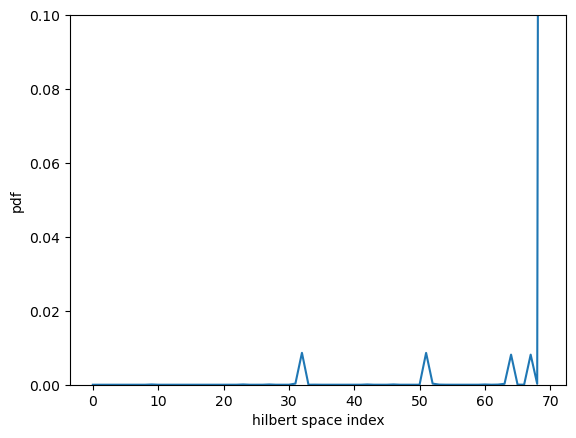

In [6]:
pars = {"params": gs_exact.state.parameters}
pdf_unnormalized = jnp.exp(2*(model.apply(pars, hi.all_states())))
pdf = pdf_unnormalized / jnp.sum(pdf_unnormalized)

plt.plot(pdf)
plt.ylim(0,0.1)
plt.xlabel("hilbert space index")
plt.ylabel("pdf")

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


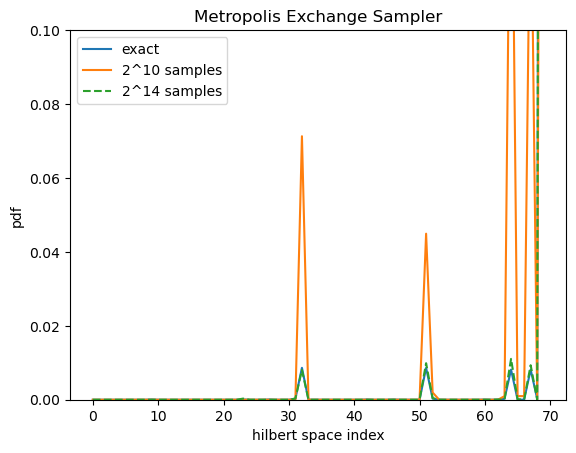

In [ ]:
exchange_graph = get_qwz_exchange_graph(L, pbc=pbc)
# We construct an Exact Sampler
sampler = nk.sampler.MetropolisExchange(hi, n_chains=1, graph = exchange_graph)

# We create the state of the sampler
sampler_state = sampler.init_state(model, pars, jax.random.key(1))

# We call reset (this will pre-compute the log_pdf on the whole hilbert space)
sampler_state = sampler.reset(model, pars, sampler_state)

# generate samples
samples, sampler_state = sampler.sample(model, pars, state=sampler_state, chain_length=10)
def estimate_pdf(n_samples):
    samples, _ = sampler.sample(model, pars, state=sampler_state, chain_length=n_samples)
    np.set_printoptions(threshold=np.inf)
    # Convert the samples to indices in the space
    idxs = hi.states_to_numbers(samples)[0]

    # count the occurrences of all indices
    return jnp.sum(idxs[:, None] == jnp.arange(hi.n_states)[None, :], axis=0) / idxs.shape[0]

plt.plot(pdf, label="exact")
plt.plot(estimate_pdf(2**10), label="2^10 samples")
plt.plot(estimate_pdf(2**14), '--', label="2^14 samples")

plt.ylim(0,0.1)
plt.title("Metropolis Exchange Sampler")
plt.xlabel("hilbert space index")
plt.ylabel("pdf")
plt.legend()

(1, 1024, 8)
(1, 16384, 8)


/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


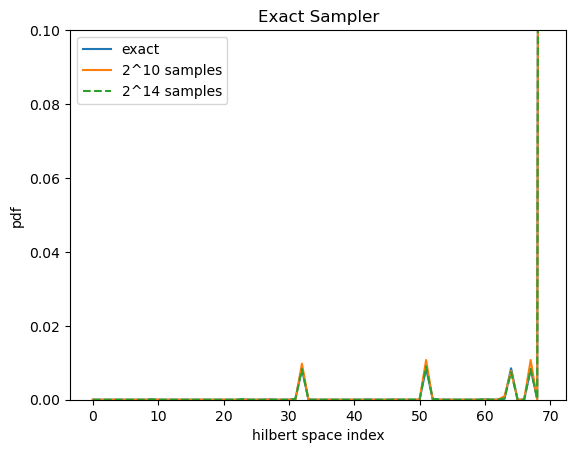

In [43]:
# We construct an Exact Sampler
sampler = nk.sampler.ExactSampler(hi)

# We create the state of the sampler
sampler_state = sampler.init_state(model, pars, jax.random.key(1))

# We call reset (this will pre-compute the log_pdf on the whole hilbert space)
sampler_state = sampler.reset(model, pars, sampler_state)

# generate samples
samples, sampler_state = sampler.sample(model, pars, state=sampler_state, chain_length=10)
def estimate_pdf(n_samples):
    samples, _ = sampler.sample(model, pars, state=sampler_state, chain_length=n_samples)
    print(samples.shape) # (1, 1024, 8)
    # Convert the samples to indices in the space
    idxs = hi.states_to_numbers(samples)[0]

    # count the occurrences of all indices
    return jnp.sum(idxs[:, None] == jnp.arange(hi.n_states)[None, :], axis=0) / idxs.shape[0]

plt.plot(pdf, label="exact")
plt.plot(estimate_pdf(2**10), label="2^10 samples")
plt.plot(estimate_pdf(2**14), '--', label="2^14 samples")

plt.title("Exact Sampler")
plt.ylim(0,0.1)
plt.xlabel("hilbert space index")
plt.ylabel("pdf")
plt.legend()

The shape of the samples is: (1, 10, 4), and the dtype is int8
[-1 -1  1  1]


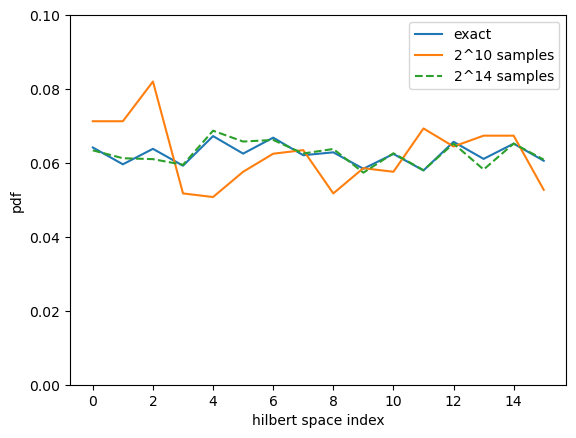

In [5]:
# We define an Hilbert space of 3 Spin-1/2
hilbert = nk.hilbert.Spin(0.5, 4)

# We define our variational ansatz
log_pdf = nk.models.RBM(param_dtype=float)

# and we initialize it's parameters
param_seed = jax.random.key(0)

pars = log_pdf.init(param_seed, hilbert.random_state(param_seed, 3))

pdf_unnormalized = jnp.exp(2*log_pdf.apply(pars, hilbert.all_states()))
pdf = pdf_unnormalized / jnp.sum(pdf_unnormalized)

# We construct an Exact Sampler
sampler = nk.sampler.ExactSampler(hilbert, dtype=jnp.int8)

# We create the state of the sampler
sampler_state = sampler.init_state(log_pdf, pars, jax.random.key(1))

# We call reset (this will pre-compute the log_pdf on the whole hilbert space)
sampler_state = sampler.reset(log_pdf, pars, sampler_state)

# generate samples
samples, sampler_state = sampler.sample(log_pdf, pars, state=sampler_state, chain_length=10)

print(f"The shape of the samples is: {samples.shape}, and the dtype is {samples.dtype}")
print(samples[0,0])

def estimate_pdf(n_samples):
    samples, _ = sampler.sample(log_pdf, pars, state=sampler_state, chain_length=n_samples)

    # Convert the samples to indices in the space
    idxs = hilbert.states_to_numbers(samples)[0]

    # count the occurrences of all indices
    return jnp.sum(idxs[:, None] == jnp.arange(hilbert.n_states)[None, :], axis=0) / idxs.shape[0]

plt.plot(pdf, label="exact")
plt.plot(estimate_pdf(2**10), label="2^10 samples")
plt.plot(estimate_pdf(2**14), '--', label="2^14 samples")

plt.ylim(0,0.1)
plt.xlabel("hilbert space index")
plt.ylabel("pdf")
plt.legend()